<a href="https://colab.research.google.com/github/amathsow/wolof_speech_recognition/blob/master/Speech_recognition_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install torchaudio
!pip install comet_ml


     |████████████████████████████████| 3.2MB 4.5MB/s 
     |████████████████████████████████| 215kB 4.5MB/s 
     |████████████████████████████████| 419kB 12.4MB/s 
     |████████████████████████████████| 204kB 19.7MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=722443d4f7b03fd6ba7b751f8fbc93daec0b62e7e4368f8597a68189a6f77cb4
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [2]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import pandas as pd
import librosa

## ETL process

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
path_audio= 'drive/My Drive/Speech Recognition project/recordings/'
path_text = 'drive/My Drive/Speech Recognition project/wolof_text/'
wav_text = 'drive/My Drive/Speech Recognition project/Wavtext_dataset2.csv'

## Data preparation for created the char.txt file from my dataset.

In [12]:
datapath = 'drive/My Drive/Speech Recognition project/data/records'

In [13]:
trainpath = '../drive/My Drive/Speech Recognition project/data/records/train/'
valpath =  '../drive/My Drive/Speech Recognition project/data/records/val/'
testpath =  '../drive/My Drive/Speech Recognition project/data/records/test/'


## Let's create the dataset

In [14]:
! git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [15]:
!pip install soundfile
!pip install torchaudio

In [16]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data

--2020-07-06 17:44:26--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt’

checkpoint_30.pt    100%[===================>] 108.34M  86.0MB/s    in 1.3s    

2020-07-06 17:44:27 (86.0 MB/s) - ‘checkpoint_data/checkpoint_30.pt’ saved [113599715/113599715]

--2020-07-06 17:44:29--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sen

In [17]:
import torch
import torchaudio

In [18]:
%cd CPC_audio/
from cpc.model import CPCEncoder, CPCAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DIM_ENCODER=256
DIM_CONTEXT=256
KEEP_HIDDEN_VECTOR=False
N_LEVELS_CONTEXT=1
CONTEXT_RNN="LSTM"
N_PREDICTIONS=12
LEARNING_RATE=2e-4
N_NEGATIVE_SAMPLE =128

/content/CPC_audio


In [19]:
encoder = CPCEncoder(DIM_ENCODER).to(device)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, 1, mode=CONTEXT_RNN).to(device)

In [20]:
# Several functions that will be necessary to load the data later
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.flac', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

In [21]:
class CPCModel(torch.nn.Module):

    def __init__(self,
                 encoder,
                 AR):

        super(CPCModel, self).__init__()
        self.gEncoder = encoder
        self.gAR = AR

    def forward(self, batch_data):
        

        encoder_output = self.gEncoder(batch_data)
        #print(encoder_output.shape)
        # The output of the encoder data does not have the good format 
        # indeed it is Batch_size x Hidden_size x temp size
        # while the context requires Batch_size  x temp size x Hidden_size
        # thus you need to permute
        context_input = encoder_output.permute(0, 2, 1)

        context_output = self.gAR(context_input)
        #print(context_output.shape)
        return context_output, encoder_output

In [22]:
datapath ='../drive/My Drive/Speech Recognition project/data/records/'
datapath2 ='../drive/My Drive/Speech Recognition project/data/'

In [23]:
!ls .. /checkpoint_data/checkpoint_30.pt

ls: cannot access '/checkpoint_data/checkpoint_30.pt': No such file or directory
..:
checkpoint_data  CPC_audio  drive  sample_data


In [24]:
%cd CPC_audio/
from cpc.dataset import parseSeqLabels
from cpc.feature_loader import loadModel

checkpoint_path = '../checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
label_dict, N_PHONES = parseSeqLabels(datapath2+'chars2.txt')
dataset_train = load_dataset(datapath+'train', file_extension='.wav', phone_label_dict=label_dict)
dataset_val = load_dataset(datapath+'val', file_extension='.wav', phone_label_dict=label_dict)
dataset_test = load_dataset(datapath+'test', file_extension='.wav', phone_label_dict=label_dict)
data_loader_train = dataset_train.getDataLoader(BATCH_SIZE, "speaker", True)
data_loader_val = dataset_val.getDataLoader(BATCH_SIZE, "sequence", False)
data_loader_test = dataset_test.getDataLoader(BATCH_SIZE, "sequence", False)

[Errno 2] No such file or directory: 'CPC_audio/'
/content/CPC_audio
Loading checkpoint ../checkpoint_data/checkpoint_30.pt
Loading the state dict at ../checkpoint_data/checkpoint_30.pt


1it [00:09,  9.21s/it]


Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/train/_seqs_cache.txt
Checking length...


995it [00:00, 1543963.18it/s]


Done, elapsed: 227.546 seconds
Scanned 995 sequences in 227.55 seconds
1 chunks computed
Joining pool


0it [00:00, ?it/s]

Joined process, elapsed=63.710 secs


1it [00:02,  2.77s/it]


Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/val/_seqs_cache.txt
Checking length...


250it [00:00, 137789.22it/s]


Done, elapsed: 79.040 seconds
Scanned 250 sequences in 79.04 seconds
1 chunks computed
Joining pool


0it [00:00, ?it/s]

Joined process, elapsed=12.194 secs


1it [00:09,  9.63s/it]


Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/test/_seqs_cache.txt
Checking length...


1231it [00:00, 375395.39it/s]


Done, elapsed: 225.518 seconds
Scanned 1231 sequences in 225.52 seconds
1 chunks computed
Joining pool
Joined process, elapsed=22.864 secs


## Create Model

In [25]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_phones : int):
    super(PhoneClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_phones)
    

  def forward(self, x):
    return self.linear(x)

In [26]:
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

In [27]:
loss_criterion = torch.nn.CrossEntropyLoss()

In [28]:
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

In [29]:
optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

In [30]:
def train_one_epoch(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader, 
                    optimizer):

  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):
    # Each batch is represented by a Tuple of vectors:
    # sequence of size : N x 1 x T
    # label of size : N x T
    # 
    # With :
    # - N number of sequence in the batch
    # - T size of each sequence
    sequence, label = full_data
    
    

    bs = len(sequence)
    seq_len = label.size(1)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))

    scores = phone_classifier(context_out)

    scores = scores.permute(0,2,1)
    loss = loss_criterion(scores,label.to(device))
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
    correct_labels = scores.argmax(1)
    avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy

In [31]:
avg_loss, avg_accuracy = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer_frozen)

In [32]:
avg_loss, avg_accuracy

(4.133836558370879, 0.07010535037878787)

In [33]:
def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):
  
  cpc_model.eval()
  phone_classifier.eval()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):
      # Each batch is represented by a Tuple of vectors:
      # sequence of size : N x 1 x T
      # label of size : N x T
      # 
      # With :
      # - N number of sequence in the batch
      # - T size of each sequence
      sequence, label = full_data
      bs = len(sequence)
      seq_len = label.size(1)
      context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))
      scores = phone_classifier(context_out)
      scores = scores.permute(0,2,1)
      loss = loss_criterion(scores,label.to(device))
      avg_loss+=loss.item()*bs
      n_items+=bs
      correct_labels = scores.argmax(1)
      avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy

In [34]:
import matplotlib.pyplot as plt
from google.colab import files

def run(cpc_model, 
        phone_classifier, 
        loss_criterion, 
        data_loader_train, 
        data_loader_val, 
        optimizer,
        n_epoch):
  epoches = []
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  for epoch in range(n_epoch):

    epoches.append(epoch)

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train, acc_train = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}. Average accuracy {acc_train}")
    train_losses.append(loss_train)
    train_accuracies.append(acc_train)

    print("-------------------")
    print("Validation dataset")
    loss_val, acc_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
    print(f"Average loss : {loss_val}. Average accuracy {acc_val}")
    print("-------------------")
    print()

    val_losses.append(loss_val)
    val_accuracies.append(acc_val)

  plt.plot(epoches, train_losses, label = "train loss")
  plt.plot(epoches, val_losses, label = "val loss")
  plt.xlabel('epoches')
  plt.ylabel('loss')
  plt.title('train and validation loss')
  plt.legend()
  # Display a figure.
  plt.savefig("loss1.png")
  files.download("loss1.png") 
  plt.show()

  plt.plot(epoches, train_accuracies, label = "train accuracy")
  plt.plot(epoches, val_accuracies, label = "vali accuracy")
  plt.xlabel('epoches')
  plt.ylabel('accuracy')
  plt.title('train and validation accuracy')
  plt.legend()
  plt.savefig("val1.png")
  files.download("val1.png") 
  # Display a figure.
  plt.show()



## The Training and Evaluating Script

Running epoch 1 / 10
-------------------
Training dataset :
Average loss : 3.9382019115216806. Average accuracy 0.1054983428030303
-------------------
Validation dataset
Average loss : 3.846985399723053. Average accuracy 0.119873046875
-------------------

Running epoch 2 / 10
-------------------
Training dataset :
Average loss : 3.7741444472110635. Average accuracy 0.13301964962121213
-------------------
Validation dataset
Average loss : 3.69957634806633. Average accuracy 0.145751953125
-------------------

Running epoch 3 / 10
-------------------
Training dataset :
Average loss : 3.6394398140184805. Average accuracy 0.15589488636363635
-------------------
Validation dataset
Average loss : 3.5785878598690033. Average accuracy 0.162841796875
-------------------

Running epoch 4 / 10
-------------------
Training dataset :
Average loss : 3.5329696120637837. Average accuracy 0.16332267992424243
-------------------
Validation dataset
Average loss : 3.4796801805496216. Average accuracy 0.16

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

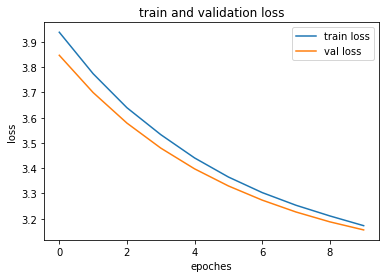

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

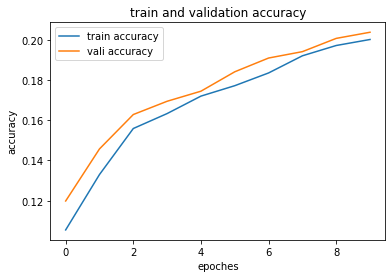

In [35]:
run(cpc_model,phone_classifier,loss_criterion,data_loader_train,data_loader_val,optimizer_frozen,n_epoch=10)

In [36]:
loss_ctc = torch.nn.CTCLoss(zero_infinity=True)

In [37]:
%cd CPC_audio/
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_per = datapath+'train'
path_val_data_per = datapath+'val'
path_phone_data_per = datapath2+'chars2.txt'
BATCH_SIZE=8

phone_labels, N_PHONES = parseSeqLabels(path_phone_data_per)
data_train_per, _ = findAllSeqs(path_train_data_per, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_per, data_train_per, phone_labels)
data_loader_train = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)

data_val_per, _ = findAllSeqs(path_val_data_per, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_per, data_val_per, phone_labels)
data_loader_val = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

1it [00:00, 76.29it/s]

[Errno 2] No such file or directory: 'CPC_audio/'
/content/CPC_audio
Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/train/_seqs_cache.txt



1it [00:00, 152.73it/s]

Loaded 996 sequences in 3.49 seconds
maxSizeSeq : 598587
maxSizePhone : 329
minSizePhone : 6
Total size dataset 0.9640946180555555 hours
Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/val/_seqs_cache.txt


Loaded 251 sequences in 1.97 seconds
maxSizeSeq : 393129
maxSizePhone : 210
minSizePhone : 7
Total size dataset 0.2305246701388889 hours


In [38]:
from cpc.feature_loader import loadModel

checkpoint_path = '../checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

Loading checkpoint ../checkpoint_data/checkpoint_30.pt
Loading the state dict at ../checkpoint_data/checkpoint_30.pt


In [39]:
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

In [40]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores.float(),y.float().to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items

  return avg_loss

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items
  #print(loss)
  return avg_loss

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            n_epoch):
  epoches = []
  train_losses = []
  val_losses = []

  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    epoches.append(epoch)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

  plt.plot(epoches, train_losses, label = "ctc_train loss")
  plt.plot(epoches, val_losses, label = "ctc_val loss")
  plt.xlabel('epoches')
  plt.ylabel('loss')
  plt.title('train and validation ctc loss')
  plt.legend()
  # Display and save a figure.
  plt.savefig("ctc_loss.png")
  files.download("ctc_loss.png") 
  plt.show()

    

Running epoch 1 / 10


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


-------------------
Training dataset :
Average loss : 35.231724966231305.
-------------------
Validation dataset
Average loss : 30.228105255126952
-------------------

Running epoch 2 / 10
-------------------
Training dataset :
Average loss : 24.906109996776486.
-------------------
Validation dataset
Average loss : 19.368375427246093
-------------------

Running epoch 3 / 10
-------------------
Training dataset :
Average loss : 15.091983853632481.
-------------------
Validation dataset
Average loss : 11.665102264404297
-------------------

Running epoch 4 / 10
-------------------
Training dataset :
Average loss : 9.78166901142753.
-------------------
Validation dataset
Average loss : 8.260225532531738
-------------------

Running epoch 5 / 10
-------------------
Training dataset :
Average loss : 7.422414722155087.
-------------------
Validation dataset
Average loss : 6.689225891113281
-------------------

Running epoch 6 / 10
-------------------
Training dataset :
Average loss : 6.2667

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

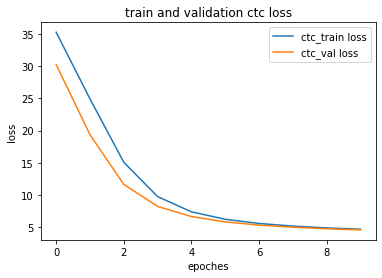

In [41]:
run_ctc(cpc_model,phone_classifier,loss_ctc,data_loader_train,data_loader_val,optimizer_frozen,n_epoch=10)

In [42]:
import numpy as np

def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  ### TODO compute the alignment

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

  #return PER

In [43]:
ref_seq = [0, 1, 1, 2, 0, 2, 2]
pred_seq = [1, 1, 2, 2, 0, 0]

expected_PER = 4. / 7.
print(get_PER_sequence(ref_seq, pred_seq) == expected_PER)

True


In [53]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 
  
  per = []
  Item = []

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_per = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]

        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)
        per.append(sum([x for x in poolData]))
        Item.append(index)

  bar.finish()

  avgPER /= nItems

  print(f"Average CER {avgPER}")

  plt.plot(Item, per, label = "Per by item")
  plt.xlabel('Items')
  plt.ylabel('PER')
  plt.title('trends of the PER')
  plt.legend()
  # Display and save a figure.
  plt.savefig("Per.png")
  files.download("Per.png") 
  plt.show()
  return avgPER

N/A% (0 of 32) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (32 of 32) |########################| Elapsed Time: 0:07:06 Time:  0:07:06


Average PER 0.7491843367846066


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

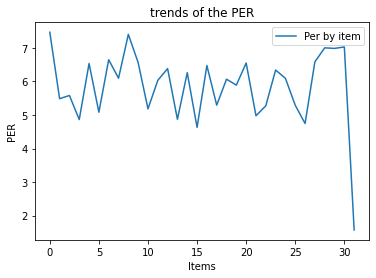

0.7491843367846066

In [45]:
get_per(data_loader_val,cpc_model,phone_classifier)

In [47]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_cer = datapath+'train'
path_val_data_cer = datapath+'val'
path_letter_data_cer = datapath2+'chars2.txt'
BATCH_SIZE=8

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)


# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.
data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

1it [00:00, 77.80it/s]

/content/CPC_audio
Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/train/_seqs_cache.txt



1it [00:00, 155.45it/s]

Loaded 996 sequences in 3.71 seconds
maxSizeSeq : 598587
maxSizePhone : 329
minSizePhone : 6
Total size dataset 0.9640946180555555 hours
Saved cache file at ../drive/My Drive/Speech Recognition project/data/records/val/_seqs_cache.txt


Loaded 251 sequences in 2.23 seconds
maxSizeSeq : 393129
maxSizePhone : 210
minSizePhone : 7
Total size dataset 0.2305246701388889 hours


In [48]:
from cpc.feature_loader import loadModel

checkpoint_path = '../checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
character_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint ../checkpoint_data/checkpoint_30.pt
Loading the state dict at ../checkpoint_data/checkpoint_30.pt


In [49]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)

In [50]:
loss_ctc = torch.nn.CTCLoss(zero_infinity=True)

Running epoch 1 / 10
-------------------
Training dataset :
Average loss : 34.74688169776495.
-------------------
Validation dataset
Average loss : 29.79711248779297
-------------------

Running epoch 2 / 10
-------------------
Training dataset :
Average loss : 24.83258881113637.
-------------------
Validation dataset
Average loss : 20.162071548461913
-------------------

Running epoch 3 / 10
-------------------
Training dataset :
Average loss : 16.316355175229173.
-------------------
Validation dataset
Average loss : 12.900087188720702
-------------------

Running epoch 4 / 10
-------------------
Training dataset :
Average loss : 10.577213947737038.
-------------------
Validation dataset
Average loss : 8.67247957611084
-------------------

Running epoch 5 / 10
-------------------
Training dataset :
Average loss : 7.440222170364916.
-------------------
Validation dataset
Average loss : 6.443285507202148
-------------------

Running epoch 6 / 10
-------------------
Training dataset :
Av

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

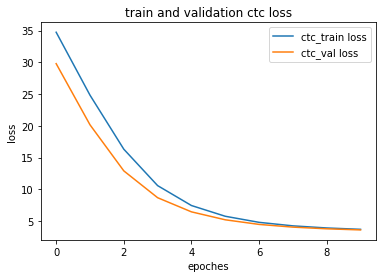

In [51]:
run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer_frozen,n_epoch=10)

N/A% (0 of 32) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (32 of 32) |########################| Elapsed Time: 0:06:46 Time:  0:06:46


Average CER 0.6837551454955654


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

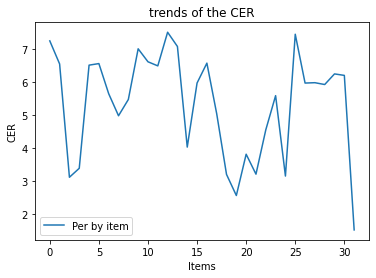

0.6837551454955654

In [54]:
get_per(data_loader_val_letters,cpc_model,character_classifier)